# Imbalanced classification

First install and import needed packages and libraries

In [1]:
# !pip install numpy scipy pandas matplotlib scikit-learn missingno imbalanced-learn pyod xgboost threadpoolctl

In [2]:
import numpy as np

We'll use a [Polish companies bankruptcy dataset](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data). The classification task is supposed to determine whether a given company will go bankrupt in the few upcoming years. The dataset is made up of 64 features designed by professional economists.

In [3]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff("polish_companies_bankruptcy_3_year_data.arff")

df = pd.DataFrame(data[0])
y = df.pop("class").astype(int)

Let's visualize the data

<Axes: >

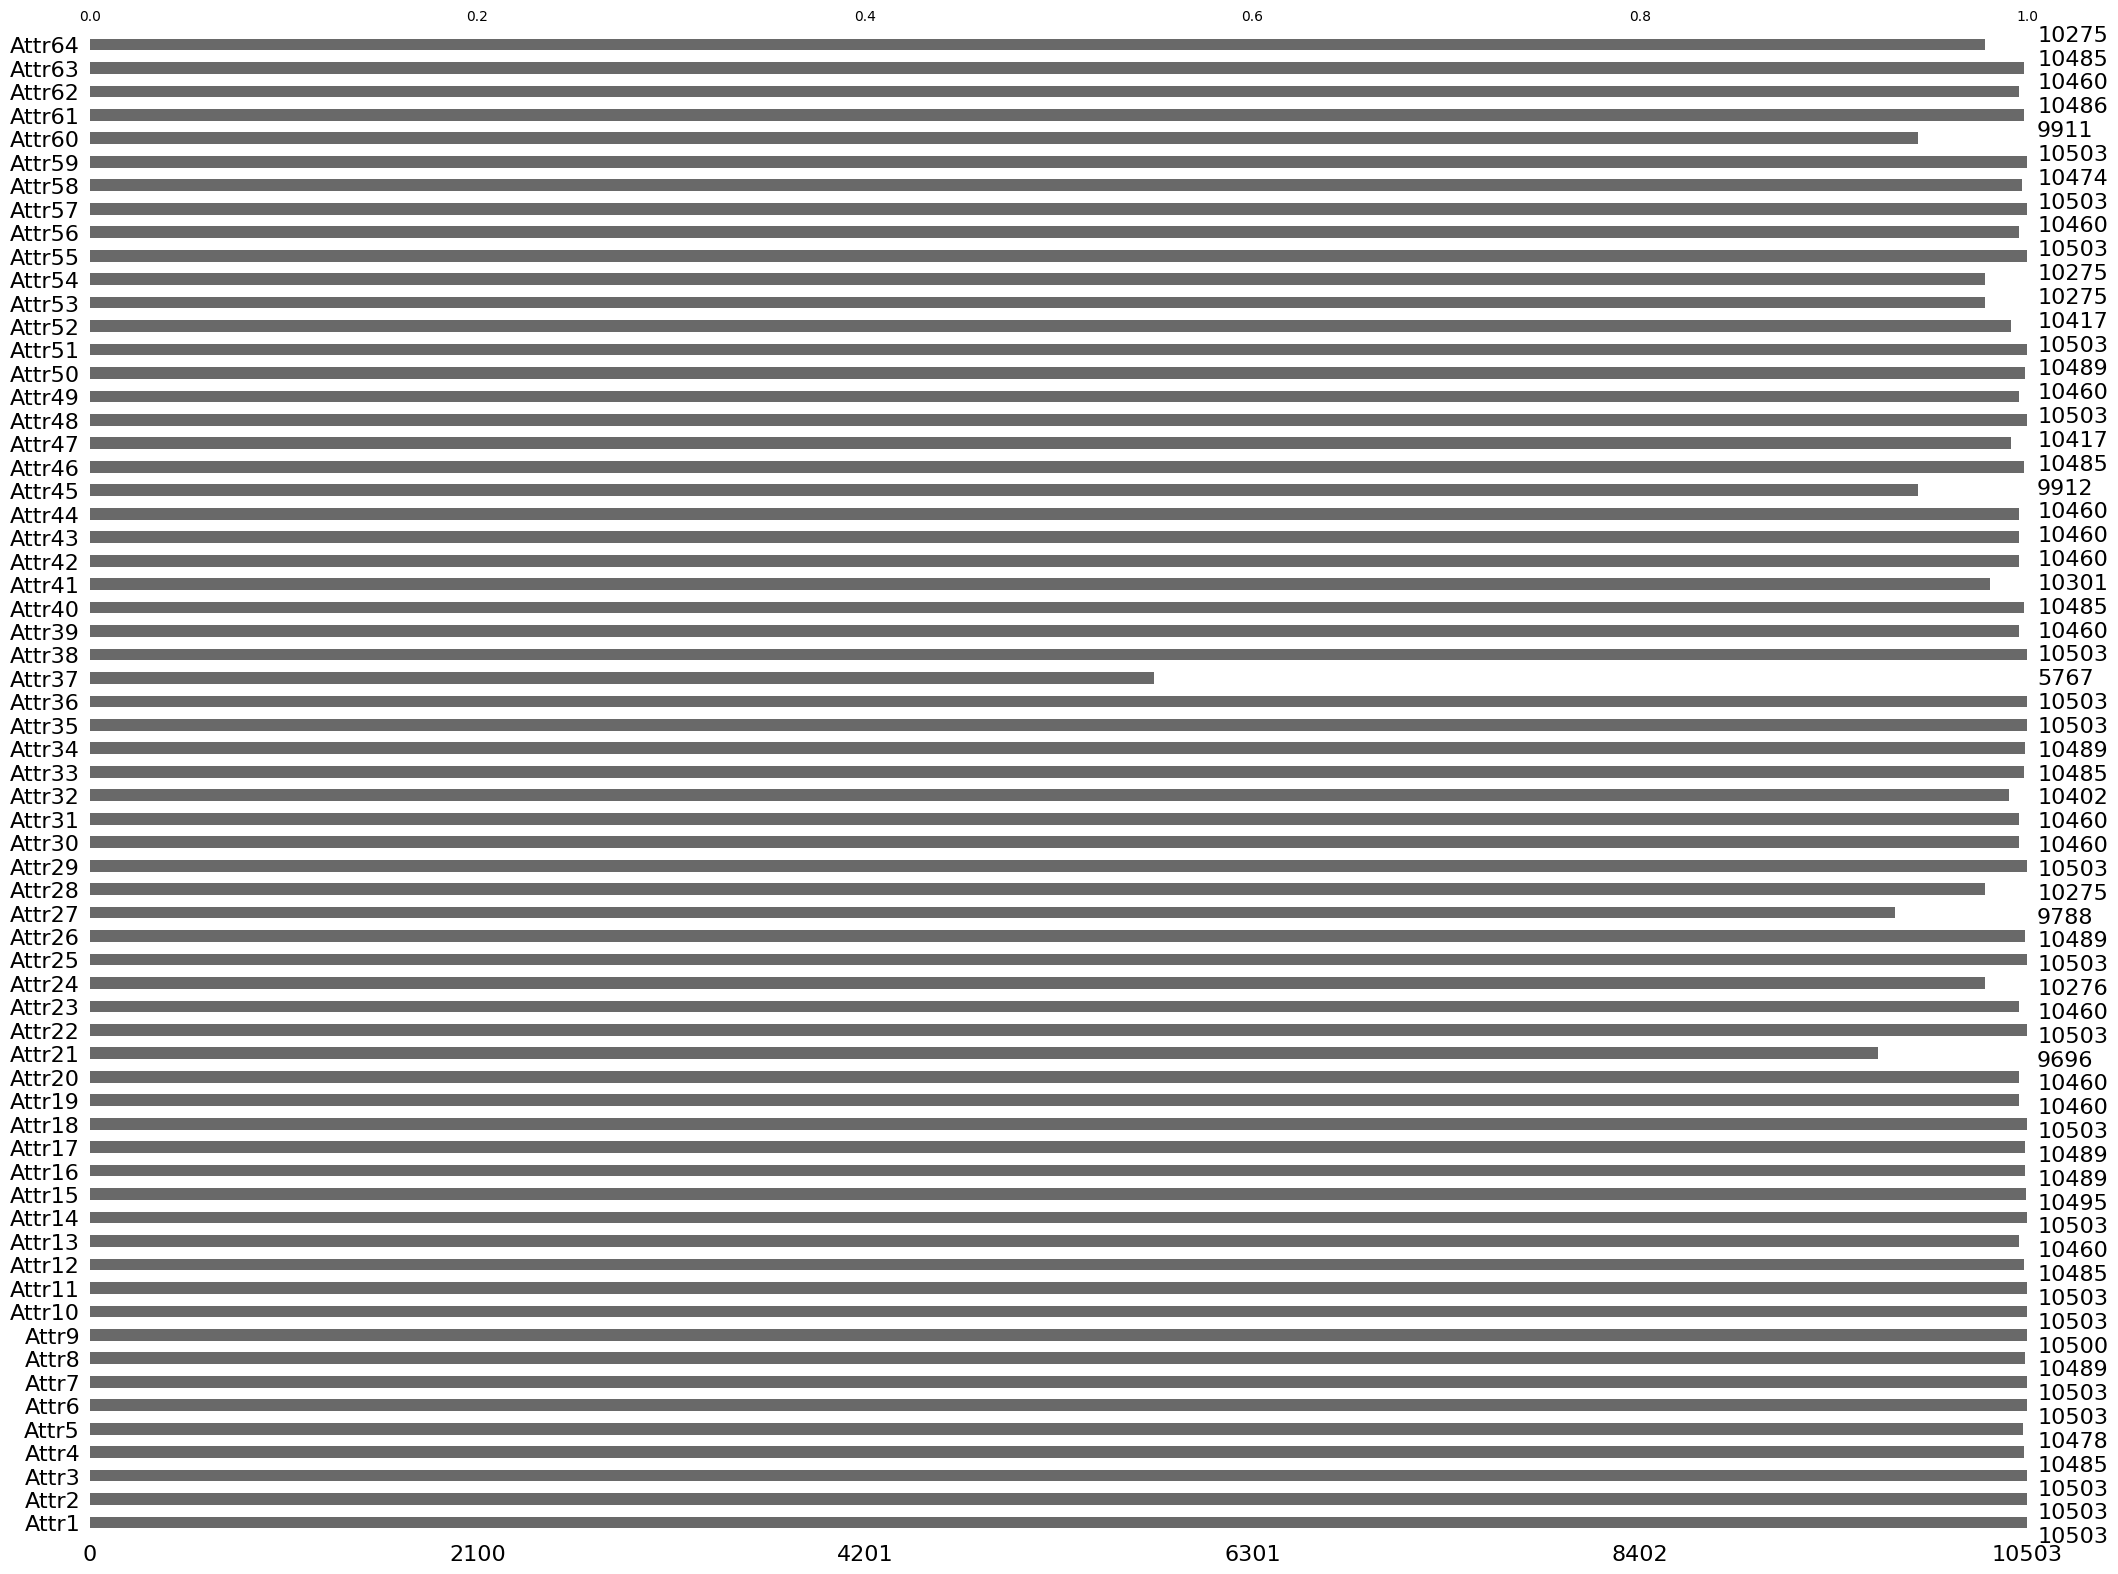

In [4]:
import missingno as msn

msn.bar(df)

We should be able to work with that after a simple preprocessing. Now what about class distribution?

<Axes: >

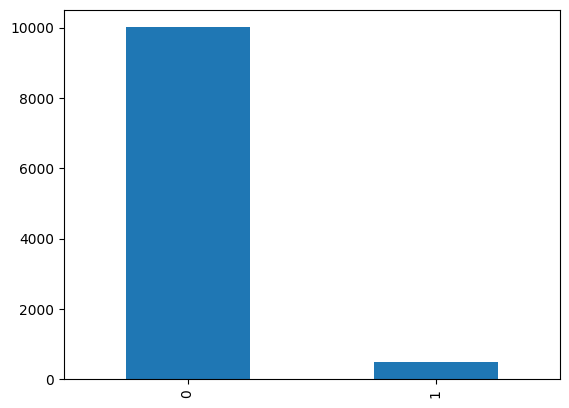

In [5]:
y.value_counts().plot.bar()

We can see a very heavy imbalance of classes

### Preprocessing

The attribute 37 has so many missing values that we should probably completely ignore it

In [6]:
df = df.drop(columns=["Attr37"])

Let's split the data into training and testing sets

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df,
    y,
    test_size=0.25,
    random_state=0,
    stratify=y,
)

Fill the missing values with mean value of each feature and scale the data

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cleaning_pipe = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler())])
X_train = cleaning_pipe.fit_transform(X_train)
X_test = cleaning_pipe.transform(X_test)

Standardization is crucial as undersampling and oversampling are usually based on nearest neighbours methods

### Cost-sensitive learning and threshold tuning

We're going to use a random forest classifier as it's easy to use and generally yields good results even without hyperparameter tuning

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score


clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)
y_pred_score = clf_rf.predict_proba(X_test)[:, 1]

auroc = roc_auc_score(y_test, y_pred_score)
f1 = f1_score(y_test, y_pred)

print(f"AUROC: {100 * auroc:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

AUROC: 87.39%
F1-score: 31.37%


We have a very good AUROC score but the F1-score shows that our results aren't that great. Maybe we can change that using cost sensitive learning?

In [10]:
estimator = RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1)
estimator.fit(X_train, y_train)

y_pred = estimator.predict(X_test)
y_pred_score = estimator.predict_proba(X_test)[:, 1]

auroc = roc_auc_score(y_test, y_pred_score)
f1 = f1_score(y_test, y_pred)

print(f"AUROC: {100 * auroc:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

AUROC: 89.30%
F1-score: 28.00%


F1 score is heavily dependent on both precision and recall so let's see the values of these 2 scores

In [11]:
from sklearn.metrics import precision_score, recall_score

print("RF")
precision = precision_score(y_test, clf_rf.predict(X_test))
recall = recall_score(y_test, clf_rf.predict(X_test))
print(f"  Precision: {100 * precision:.2f}%")
print(f"  Recall: {100 * recall:.2f}%")

print()

print("RF with cost-sensitive learning")
precision = precision_score(y_test, estimator.predict(X_test))
recall = recall_score(y_test, estimator.predict(X_test))
print(f"  Precision: {100 * precision:.2f}%")
print(f"  Recall: {100 * recall:.2f}%")

RF
  Precision: 82.76%
  Recall: 19.35%

RF with cost-sensitive learning
  Precision: 80.77%
  Recall: 16.94%


High precision value means that our model is able to pick up many instances of the positive class. However, low recall means that too many elements are classified as positive class. The model makes to many positive classifications.

Maybe we can improve this score by performing a threshold tuning?

In [12]:
def threshold_f1_score(y_true, y_score, threshold: float, **kwargs) -> float:
    y_pred = y_score >= threshold
    return f1_score(y_true, y_pred, **kwargs)

In [13]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score


thresholds = np.arange(0.1, 0.5, 0.05)
f1_scores = []

for threshold in thresholds:
    scorer = make_scorer(
        threshold_f1_score,
        threshold=threshold,
        needs_proba=True,
        greater_is_better=True,
    )
    scores = cross_val_score(
        estimator=estimator,
        X=X_train,
        y=y_train,
        scoring=scorer,
        cv=5,
    )
    cv_score = np.mean(scores)
    f1_scores.append(cv_score)

for r, t in zip(f1_scores, thresholds):
    print("{:.2f}".format(round(t, 2)), "-", np.mean(r))

0.10 - 0.36844826513530665
0.15 - 0.4538190856115974
0.20 - 0.4298000925574623
0.25 - 0.42711641775861964
0.30 - 0.36401192617183964
0.35 - 0.3341314721279022
0.40 - 0.29172865781561436
0.45 - 0.2503172241016352


Let's visualize the scores!

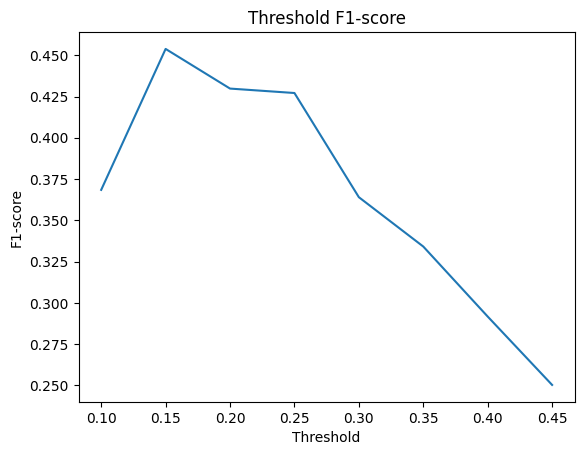

In [14]:
from matplotlib import pyplot as plt

plt.plot(thresholds, f1_scores)
plt.title("Threshold F1-score")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.show()

In [31]:
threshold = thresholds[np.argmax(f1_scores)]

y_score = estimator.predict_proba(X_test)[:, 1]
y_pred = y_score >= threshold

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_score)

print(f"AUROC for best threshold     : {100 * auroc:.2f}%")
print(f"F1-score for best threshold  : {100 * f1:.2f}%")
print(f"Precision for best threshold : {100 * precision:.2f}%")
print(f"Recall for best threshold    : {100 * recall:.2f}%")

AUROC for best threshold     : 89.30%
F1-score for best threshold  : 42.97%
Precision for best threshold : 41.67%
Recall for best threshold    : 44.35%


We managed to improve oth recall and f1 score simpy by tuning the threshold!

### Undersampling and oversampling

Let's downsample the negative class. In some cases because of lucky circumstances, some companies that should have gone bankrupt managed to stay in the business. We can remove them using Edited Nearest Neighbors algorithms (ENNs). We'll remove elements that have at least one nearest neighbor from positive class.

In [28]:
# method for assessing classifier performance
def assess_rf_performance(estimator, X_test, y_test, threshold=0.5) -> None:
    y_score = estimator.predict_proba(X_test)[:, 1]
    y_pred = estimator.predict_proba(X_test)[:, 1] >= threshold

    auroc = roc_auc_score(y_test, y_score)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"AUROC     : {100 * auroc:.2f}%")
    print(f"F1-score  : {100 * f1:.2f}%")
    print(f"Precision : {100 * precision:.2f}%")
    print(f"Recall    : {100 * recall:.2f}%")

In [18]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(n_neighbors=3, kind_sel="all")
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)
print(f"Samples before ENN : {len(X_train)}")
print(f"Samples after ENN  : {len(X_train_enn)}")
print()

clf_rf_csl = RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1)
clf_rf_csl.fit(X_train_enn, y_train_enn)

assess_rf_performance(clf_rf_csl, X_test, y_test)

Samples before ENN: 7877
Samples after ENN: 7005
AUROC     : 87.43%
F1-score  : 24.66%
Precision : 81.82%
Recall    : 14.52%


We can observe performance loss. Let's see if we can improve with hyperparameter tuning

In [19]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

enn_rfc_pipe = Pipeline(
    [
        ("enn", EditedNearestNeighbours()),
        (
            "rfc",
            RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1),
        ),
    ]
)

param_grid = {"enn__n_neighbors": [1, 3, 5], "enn__kind_sel": ["all", "mode"]}

cv = GridSearchCV(
    estimator=enn_rfc_pipe, param_grid=param_grid, scoring="roc_auc", cv=10, n_jobs=-1
)

cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('enn', EditedNearestNeighbours()),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'enn__kind_sel': ['all', 'mode'],
                         'enn__n_neighbors': [1, 3, 5]},
             scoring='roc_auc')

In [20]:
print(cv.best_params_)
assess_rf_performance(cv, X_test, y_test)

{'enn__kind_sel': 'mode', 'enn__n_neighbors': 5}
AUROC     : 87.45%
F1-score  : 28.19%
Precision : 84.00%
Recall    : 16.94%


We managed to slightly improve the F1 score

In [29]:
enn = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5)
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)
print(f"Samples before ENN : {len(X_train)}")
print(f"Samples after ENN  : {len(X_train_enn)}")

Samples before ENN: 7877
Samples after ENN: 7858


What about using the previously found threshold?

In [30]:
threshold = thresholds[np.argmax(f1_scores)]

y_score = estimator.predict_proba(X_test)[:, 1]
y_pred = y_score >= threshold
assess_rf_performance(estimator, X_test, y_test, 0.15)

AUROC     : 87.45%
F1-score  : 44.53%
Precision : 40.67%
Recall    : 49.19%


Our scores are still lower but we improved recall

Let's see if using SMOTE can helps us

In [41]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Samples before SMOTE : {len(X_train)}")
print(f"Samples after SMOTE  : {len(X_train_smote)}")

clf_rf_csl = RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1)
clf_rf_csl.fit(X_train_smote, y_train_smote)

assess_rf_performance(clf_rf_csl, X_test, y_test)

Samples before SMOTE : 7877
Samples after SMOTE  : 15012
AUROC     : 88.16%
F1-score  : 46.01%
Precision : 55.06%
Recall    : 39.52%


Upsampling the positive class enables us to improve both precision and recall!

In [42]:
print("Train metrics")
assess_rf_performance(clf_rf_csl, X_train, y_train)
print()
print("Test metrics")
assess_rf_performance(clf_rf_csl, X_test, y_test)

Train metrics
AUROC     : 100.00%
F1-score  : 100.00%
Precision : 100.00%
Recall    : 100.00%

Test metrics
AUROC     : 88.16%
F1-score  : 46.23%
Precision : 55.68%
Recall    : 39.52%


The overfitting is terrible. Let's tune SMOTE hyperparameters. It takes long time to tune all of them so let's tune separately. It might not give the ideal results but can let us achieve decent performance

In [43]:
enn_smote_pipe1 = Pipeline(
    [
        ("smote", SMOTE(random_state=0)),
        (
            "rfc",
            RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1),
        ),
    ]
)

enn_smote_pipe2 = Pipeline(
    [
        ("smote", SMOTE(random_state=0)),
        (
            "rfc",
            RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1),
        ),
    ]
)

param_grid1 = {"smote__k_neighbors": [1, 2, 3, 4, 5]}
param_grid2 = {"smote__sampling_strategy": np.arange(0.25, 1.25, 0.25)}

cv1 = GridSearchCV(
    estimator=enn_smote_pipe1,
    param_grid=param_grid1,
    scoring="roc_auc",
    cv=10,
    n_jobs=-1,
    verbose=4,
)

cv2 = GridSearchCV(
    estimator=enn_smote_pipe2,
    param_grid=param_grid2,
    scoring="roc_auc",
    cv=10,
    n_jobs=-1,
    verbose=4,
)

cv1.fit(X_train, y_train)
cv2.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=0)),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'smote__sampling_strategy': array([0.25, 0.5 , 0.75, 1.  ])},
             scoring='roc_auc', verbose=4)

In [46]:
print(cv1.best_params_)
print(cv2.best_params_)

{'smote__k_neighbors': 3}
{'smote__sampling_strategy': 0.25}


In [49]:
print("cv1 - test")
assess_rf_performance(cv1.best_estimator_["rfc"], X_test, y_test)
print()
print("cv1 - train")
assess_rf_performance(cv1.best_estimator_["rfc"], X_train, y_train)
print()
print("cv2 - test")
assess_rf_performance(cv2.best_estimator_["rfc"], X_test, y_test)
print()
print("cv2 - train")
assess_rf_performance(cv2.best_estimator_["rfc"], X_train, y_train)
print()

cv1 - test
AUROC     : 89.38%
F1-score  : 49.52%
Precision : 60.47%
Recall    : 41.94%

cv1 - train
AUROC     : 100.00%
F1-score  : 100.00%
Precision : 100.00%
Recall    : 100.00%

cv2 - test
AUROC     : 89.62%
F1-score  : 38.15%
Precision : 67.35%
Recall    : 26.61%

cv2 - train
AUROC     : 100.00%
F1-score  : 100.00%
Precision : 100.00%
Recall    : 100.00%


Let's try to combine the 2 best results

In [53]:
best_pipe = Pipeline(
    [
        ("smote", SMOTE(random_state=0, k_neighbors=3, sampling_strategy=0.25)),
        (
            "rfc",
            RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1),
        ),
    ]
)

best_pipe.fit(X_train, y_train)

print("test")
assess_rf_performance(best_pipe, X_test, y_test)
print("\ntrain")
assess_rf_performance(best_pipe, X_train, y_train)

test
AUROC     : 90.36%
F1-score  : 38.86%
Precision : 66.67%
Recall    : 27.42%

train
AUROC     : 100.00%
F1-score  : 100.00%
Precision : 100.00%
Recall    : 100.00%


The result is worse than with first tuned model alone.

Let's try to combne oversampling with undersampling

In [56]:
from imblearn.combine import SMOTEENN

smote_enn_pipeline = Pipeline(
    [
        ("smoteenn", SMOTEENN(random_state=0)),
        (
            "rf",
            RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1),
        ),
    ]
)
smote_enn_pipeline.fit(X_train, y_train)

test
AUROC     : 87.51%
F1-score  : 39.50%
Precision : 41.23%
Recall    : 37.90%

train
AUROC     : 99.87%
F1-score  : 74.47%
Precision : 59.52%
Recall    : 99.46%


The results are acceptable but we still had better scores with threshold tuning

In [63]:
print("test")
assess_rf_performance(smote_enn_pipeline, X_test, y_test)
print("\ntrain")
assess_rf_performance(smote_enn_pipeline, X_train, y_train)

test
AUROC     : 87.51%
F1-score  : 40.38%
Precision : 33.51%
Recall    : 50.81%

train
AUROC     : 99.87%
F1-score  : 74.47%
Precision : 59.52%
Recall    : 99.46%


Now how about smote with our discovered hyperparameters?

In [67]:
smote_enn_pipeline = Pipeline(
    [
        ("enn", EditedNearestNeighbours(kind_sel="mode", n_neighbors=5)),
        ("smote", SMOTE(random_state=0, k_neighbors=3)),
        (
            "rf",
            RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1),
        ),
    ]
)
smote_enn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('enn',
                 EditedNearestNeighbours(kind_sel='mode', n_neighbors=5)),
                ('smote', SMOTE(k_neighbors=3, random_state=0)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=0))])

In [81]:
print("test")
assess_rf_performance(smote_enn_pipeline, X_test, y_test)
print("\ntrain")
assess_rf_performance(smote_enn_pipeline, X_train, y_train)

test
AUROC     : 88.39%
F1-score  : 44.34%
Precision : 53.41%
Recall    : 37.90%

train
AUROC     : 99.99%
F1-score  : 99.60%
Precision : 99.20%
Recall    : 100.00%


It looks like we finally got to the level similar to threshold tuning. We still had to use different threshold, but it should be alright